In [1]:
import sqlite3
from collections import defaultdict
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pytz

In [2]:
df_short = pd.read_parquet('df_short.gzip')
df_versions = pd.read_parquet('df_versions.gzip')

# Hack for untagged versions
df_versions.loc['0.9.1'] = df_versions.loc['0.9']['release_date']
df_versions.loc[''] = df_versions.loc['0.1']['release_date']
df_versions.loc['others'] = df_versions.loc['0.1']['release_date']
df_versions.loc['0'] = df_versions.loc['0.1']['release_date']
df_versions.loc['0+unknown'] = df_versions.loc['0.1']['release_date']

df_versions.sort_values(by='release_date', inplace=True)

In [3]:
## Order Versions based on release date

In [4]:
def get_base_version(ver):
    base_ver = ver.split('-', maxsplit=1)[0].split('+', maxsplit=1)[0]

    if not base_ver in df_versions.index:
        print(f'Error: unknown base version {base_ver}')
        base_ver = ''

    return base_ver

for ver in df_short.index:
    base_ver = get_base_version(ver)
    if base_ver == '':
        print(f'Error: No release date or base version known for tag: \'{ver}\'')

In [5]:
def version2date(version):
    base_version = get_base_version(str(version))
    return df_versions.loc[base_version]['release_date'].to_pydatetime()

def versions2dates(versions):
    return [version2date(version) for version in versions]

In [6]:
df_short.sort_index(ascending=False, key=versions2dates, inplace=True)

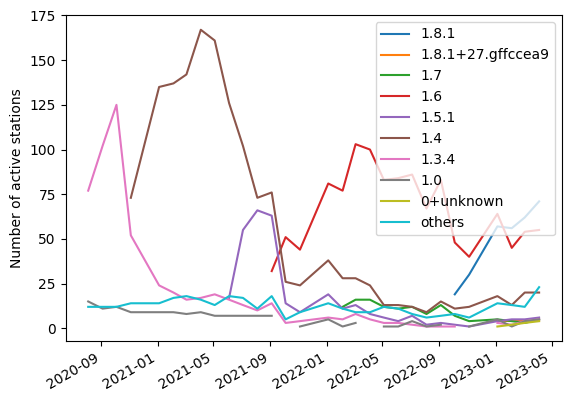

In [7]:
df_short.transpose().plot().legend(loc='upper right')
plt.ylabel('Number of active stations')
plt.show()

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.figsize']

[6.4, 4.8]

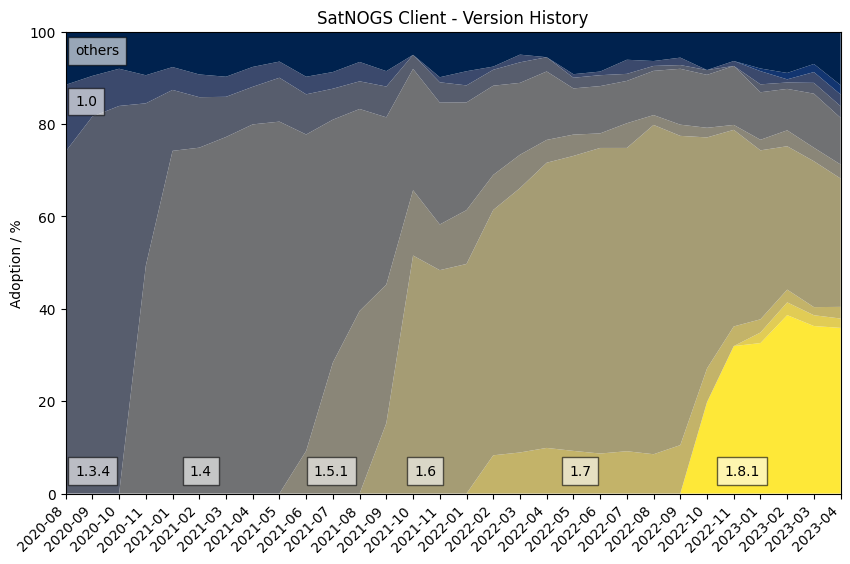

In [39]:
df_percent = (df_short / df_short.sum() * 1e2)

x = [f'{d:%Y-%m}' for d in df_percent.columns.to_pydatetime()]
y = df_percent.fillna(0).values
labels = df_percent.index
colors = plt.cm.cividis.resampled(df_short.index.shape[0]).colors
colors = reversed(colors)

fig = plt.figure(figsize=(10.0,6.0))
# fig = plt.figure()
ax = fig.subplots()

ax.stackplot(x, y, labels=labels, colors=colors)

handles, labels = ax.get_legend_handles_labels()

label_position = ['distributed']

if 'box' in label_position:
    ax.legend(handles[::-1], labels[::-1], title='Version', loc='upper left')

if 'side' in label_position:
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

if 'distributed' in label_position:
    ls = [[0.85, 0.04, labels[0]],
          [0.65, 0.04, labels[2]],
          [0.45, 0.04, labels[3]],
          [0.32, 0.04, labels[4]],
          [0.16, 0.04, labels[5]],
          [0.012, 0.04, labels[6]],
          [0.012, 0.84, labels[7]],
          [0.012, 0.95, labels[9]],
         ]
    for l in ls:
        ax.text(l[0],l[1],l[2],
                transform=ax.transAxes,
                bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 5}
           )

plt.xticks(rotation=45, ha="right")
ax.set_ylim((0,100))
ax.set_xlim((x[0], x[-1]))
plt.ylabel('Adoption / %')
plt.title('SatNOGS Client - Version History')
plt.show()

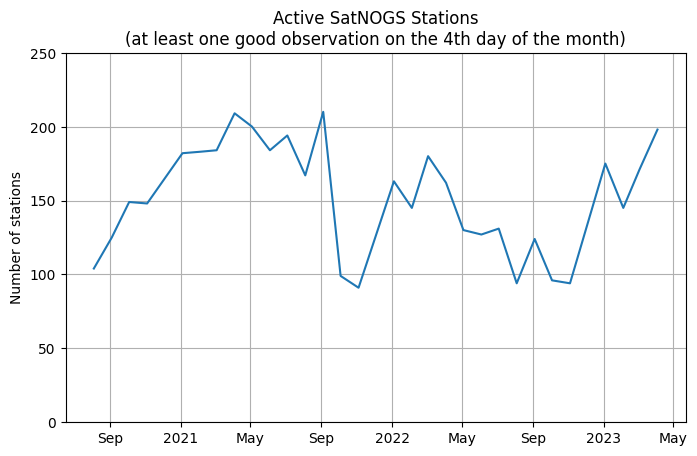

In [38]:
x = df_short.columns
y = df_short.sum().values

fig = plt.figure(figsize=(8.0,4.8))
ax = fig.subplots()

ax.plot(x,y)
# plt.xticks(rotation=45, ha="right")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
labels = ax.get_xticklabels()
# plt.setp(labels, rotation=45)

if False:
    # tick on each month
    loc_year = mpl.dates.YearLocator()
    loc_month = mpl.dates.MonthLocator(bymonth=[1,4,7,10])
    ax.xaxis.set_major_locator(loc_year, )
    ax.xaxis.set_minor_locator(loc_month)
else:
    locator = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
ax.set_ylabel('Number of stations')
ax.set_title("Active SatNOGS Stations\n(at least one good observation on the 4th day of the month)")
ax.set_ylim([0,250])
ax.grid()
plt.show()